In [3]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from stabilizer_utils import *
from HMM_utils import *


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files = glob.glob('D:/T5_ClosedLoop/*')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### train linear regression on day 0, get baseline performance measure


In [8]:
from recalibration_utils import *

# Get initial day performance and decoder:

day0       = DataStruct(files[2])
train_frac = 0.5
task       = 'cursor'

day0_r2, day0_decoder = traintest_DecoderSupervised(day0, train_frac = train_frac, task = task)


print('Performance on day 0 with recalibration: R^2 = ',day0_r2)

Performance on day 0 with recalibration: R^2 =  0.3314413769391978


In [20]:
from recalibration_utils import *
from copy import deepcopy

train_frac = 0.5
task       = 'cursor'

date         = [day0.date]
models       = list()
scores       = np.zeros((4, 12)) # rows are 0 - no recalibration; 1 - mean recalibration; 2 - full recalibration; 3 - HMM recalibration
scores[:, 0] = day0_r2

# HMM setup:
gridSize     = 20
X_min, X_max = day0.targetPos_continuous[:, 0].min() - 20, day0.targetPos_continuous[:, 0].max() + 20
Y_min, Y_max = day0.targetPos_continuous[:, 1].min() - 20, day0.targetPos_continuous[:, 1].max() + 20
X_loc,Y_loc  = np.meshgrid(np.linspace(X_min, X_max, gridSize), np.linspace(Y_min, Y_max, gridSize))
targLocs     = np.vstack([np.ravel(X_loc), np.ravel(Y_loc[:])]).T

# No information about goal switching structure - assume equal probability of transitioning to any other spot (but likely hanging in current spot)
stayProb = 0.9999
nStates  = gridSize**2

#Define the state transition matrix, which has a uniform transition probability among states
stateTrans = np.eye(nStates)*stayProb

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
pStateStart = np.zeros((nStates,1)) + 1/nStates


hmmtrained_decoder = deepcopy(day0_decoder)  # this will update each new day
for i in range(11):
#for i in range(1):
    file        = files[i + 3]
    new_day     = DataStruct(file)
    date.append(new_day.date)
    
    # 0th column is reserved for initial day decoder performance:
    scores[0, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = deepcopy(day0_decoder), adapt_means = False, train_frac = train_frac, task = task)
    scores[1, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = deepcopy(day0_decoder), adapt_means = True, train_frac = train_frac, task = task)
    scores[2, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = None, train_frac = train_frac, task = task)
    
    # Precision parameter for the von mises distribution.
    hmm_score, _, r2 = traintest_DecoderHMMUnsupervised(struct = new_day, decoder = hmmtrained_decoder, stateTrans = stateTrans, pStateStart = pStateStart, 
                                                        targLocs = targLocs, vmKappa = 2, probThreshold = 0.6, train_frac = 0.5, task = 'cursor')
                                                       
    scores[3, i + 1] = hmm_score
    


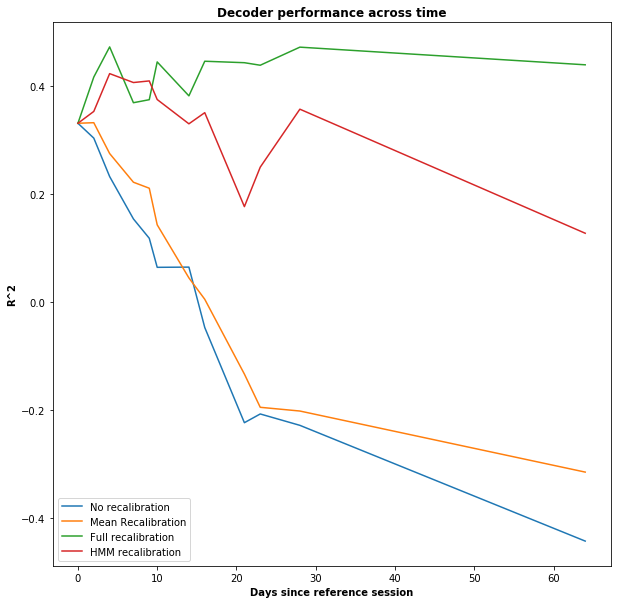

In [21]:
from preprocess import daysBetween
days = [daysBetween(day0.date, date[i]) for i in range(len(date))]


figSize(10, 10)

labels = ['No recalibration', 'Mean Recalibration', 'Full recalibration', 'HMM recalibration']
for i in range(4):
    plt.plot(days, scores[i, :].T, label = labels[i])
    
plt.xlabel('Days since reference session', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
#plt.xticks(np.arange(len(date)), date, rotation = 40, fontweight = 'bold')
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()

In [ ]:
COPY REFERENCE BLCOk

In [13]:
from recalibration_utils import *
from copy import deepcopy

train_frac = 0.5
task       = 'cursor'

date         = [day0.date]
models       = list()
scores       = np.zeros((4, 12)) # rows are 0 - no recalibration; 1 - mean recalibration; 2 - full recalibration; 3 - HMM recalibration
scores[:, 0] = day0_r2

# HMM setup:
gridSize     = 20
X_min, X_max = day0.targetPos_continuous[:, 0].min() - 20, day0.targetPos_continuous[:, 0].max() + 20
Y_min, Y_max = day0.targetPos_continuous[:, 1].min() - 20, day0.targetPos_continuous[:, 1].max() + 20
X_loc,Y_loc  = np.meshgrid(np.linspace(X_min, X_max, gridSize), np.linspace(Y_min, Y_max, gridSize))
targLocs     = np.vstack([np.ravel(X_loc), np.ravel(Y_loc[:])]).T

# No information about goal switching structure - assume equal probability of transitioning to any other spot (but likely hanging in current spot)
stayProb = 0.9999
nStates  = gridSize**2

#Define the state transition matrix, which has a uniform transition probability among states
stateTrans = np.eye(nStates)*stayProb

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
pStateStart = np.zeros((nStates,1)) + 1/nStates


hmmtrained_decoder = deepcopy(day0_decoder)  # this will update each new day
for i in range(11):
#for i in range(1):
    file        = files[i + 3]
    new_day     = DataStruct(file)
    date.append(new_day.date)
    
    # 0th column is reserved for initial day decoder performance:
    scores[0, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = deepcopy(day0_decoder), adapt_means = False, train_frac = train_frac, task = task)
    scores[1, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = deepcopy(day0_decoder), adapt_means = True, train_frac = train_frac, task = task)
    scores[2, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = None, train_frac = train_frac, task = task)
    
    # Precision parameter for the von mises distribution.
    vmKappa = 2

    '''
    Infer target locations from the raw decoder output and cursor positions using the viterbi algorithm (finds most likely sequence) and the
    forwards/backwards algorithm (to find the probabilities). These are custom functions that I made by modifying the MATLAB hmm routines 
    (hmmviterbi & hmmdecode). '''
    
    features             = np.vstack([new_day.TX[i] for i in np.where(new_day.trialType == task)[0] ])
    cursorPos            = np.vstack([new_day.cursorPos[i] for i in np.where(new_day.trialType == task)[0] ])
    targetPos            = np.vstack([new_day.targetPos[i] - new_day.cursorPos[i] for i in np.where(new_day.trialType == task)[0] ])
    targets              = targetPos - cursorPos
    n_samples, n_chans   = features.shape[0], features.shape[1]
    
    train_samples       = int(train_frac * n_samples)
    train_x, test_x     = features[:train_samples, :], features[train_samples:, :]
    train_y, test_y     = targets[:train_samples, :], targets[train_samples:, :]
    session_means       = train_x.mean(axis = 0)
    
    posTraj    = np.vstack([new_day.cursorPos[i] for i in np.where(new_day.trialType == task)[0] ])[:train_samples, :]
    rawDecTraj = hmmtrained_decoder.predict(train_x - session_means)
    
    targStates, logP = hmmviterbi_vonmises(rawDecTraj, stateTrans, targLocs, posTraj, pStateStart, vmKappa)
    pTargState, pSeq = hmmdecode_vonmises(rawDecTraj, stateTrans, targLocs, posTraj, pStateStart, vmKappa)

    targStates = np.asarray(targStates)
    pTargState = np.asarray(pTargState)

    #We can find time periods of high certainty, which may be of interest.
    maxProb     = np.max(pTargState, axis = 0)
    highProbIdx = np.where(maxProb > 0.5)[0]
    
    # now retrain HMM decoder, store for a new day:
    inferredTargLoc = targLocs[targStates.astype('int').flatten() - 1,:]
    inferredPosErr  = inferredTargLoc - cursorPos[:train_samples, :]
    hmmtrained_decoder.fit((train_x - session_means)[highProbIdx, :], inferredPosErr[highProbIdx, :])
    scores[3, i + 1] = hmmtrained_decoder.score(test_x - session_means, test_y)
    
   

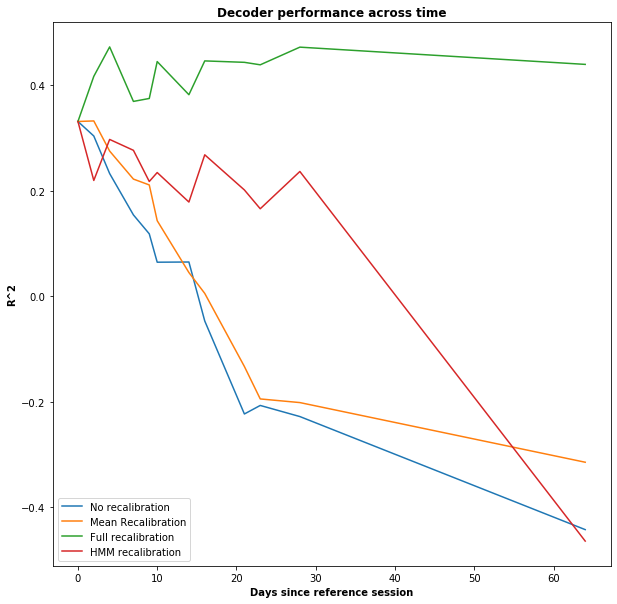

In [14]:
from preprocess import daysBetween
days = [daysBetween(day0.date, date[i]) for i in range(len(date))]


figSize(10, 10)

labels = ['No recalibration', 'Mean Recalibration', 'Full recalibration', 'HMM recalibration']
for i in range(4):
    plt.plot(days, scores[i, :].T, label = labels[i])
    
plt.xlabel('Days since reference session', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
#plt.xticks(np.arange(len(date)), date, rotation = 40, fontweight = 'bold')
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()